In [1]:
from __future__ import print_function

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
sys.path.insert(0, '../py')
from graviti import *

import numpy as np
import scipy as sp
from scipy.sparse import coo_matrix
import scipy.ndimage as ndi

from skimage.draw import polygon
from skimage import io
from skimage.measure import label, regionprops
import skimage.io
import skimage.measure
import skimage.color

import glob
import pickle
import pandas as pd
import os
import timeit
import random

import pyvips

import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import umap
import seaborn as sns; sns.set()

In [2]:
def get_LogCovMat_parallel(featureMat):
    out = np.real(sp.linalg.logm(np.cov(featureMat,rowvar=False))).flatten()
    return out
def get_LogCorrMat_parallel(featureMat):
    return np.real(sp.linalg.logm(np.corrcoef(featureMat,rowvar=False))).flatten()
def get_position_parallel(featureMat):
    pos = featureMat[0]
    return pos

In [3]:
patches = glob.glob('/home/garner1/pipelines/nucleAI/data/TCGA-05-4402-01Z-00-DX1/*.pkl')

In [19]:
intensity_features = []
for patch in patches[:]:
    #print(patch)
    infile = open(patch,'rb')
    lista = pickle.load(infile)
    intensity_features.extend(lista)
    infile.close()
print(len(intensity_features))

3649


In [20]:
list_of_features = random.sample(intensity_features,3000)

In [21]:
num_cores = multiprocessing.cpu_count() # numb of cores

In [22]:
pos = Parallel(n_jobs=num_cores)( delayed(get_position_parallel)(f) for f in tqdm(intensity_features) if f is not None)
data_cov = Parallel(n_jobs=num_cores)( delayed(get_LogCovMat_parallel)(f[1]) for f in tqdm(intensity_features) if f is not None)
data_corrcoef = Parallel(n_jobs=num_cores)( delayed(get_LogCorrMat_parallel)(f[1]) for f in tqdm(intensity_features) if f is not None)

#Get data in a serial way
#pos = np.array([f[0] for f in list_of_features if f is not None])  
#data_cov = np.array([np.real(sp.linalg.logm(np.cov(f[1],rowvar=False))).flatten() for f in list_of_features if f is not None])  
#data_corrcoef = np.array([np.real(sp.linalg.logm(np.corrcoef(f[1],rowvar=False))).flatten() for f in list_of_features if f is not None])  

100%|██████████| 3649/3649 [00:11<00:00, 318.91it/s]


In [23]:
reducer = umap.UMAP(n_components=2,min_dist=0,n_neighbors=10)
embedding = reducer.fit_transform(data_cov)

# Define dataframe in lowD
df =  pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1]))

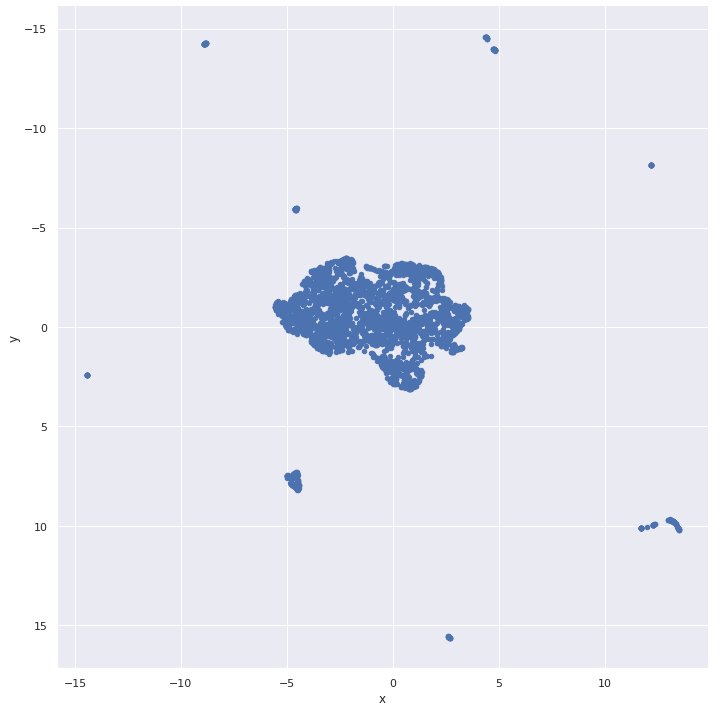

In [24]:
import seaborn
ax = seaborn.FacetGrid(data=df,height=10, aspect=1)
ax.map(plt.scatter, 'x', 'y',s=20).add_legend()
plt.gca().invert_yaxis()

In [13]:
barycenter_cov = np.mean(data_cov,axis=0)
dist = sp.linalg.norm(data_cov-barycenter_cov,axis=1)
print(np.mean(dist),np.std(dist),np.cov(dist))

2.1313839926364904 0.7192526234090215 0.5174003128318362


In [ ]:
ax = seaborn.FacetGrid(data=df_plot[['x','y','cluster']], 
                       hue='cluster',
                       height=10, aspect=1)
ax.map(plt.scatter, 'x', 'y',s=20).add_legend()
plt.gca().invert_yaxis()

In [ ]:
# K-means classification
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
df = df_plot[df_plot['cluster']==3]
db = hdbscan.HDBSCAN(min_cluster_size=10).fit(df[['x_umap','y_umap']]
)
#kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

df['cluster_B'] = db.labels_

# Show the cluster to study
import seaborn
seaborn.set(style='white')

fg = seaborn.FacetGrid(data=df[['x_umap','y_umap','cluster_B']], 
                       height=10, aspect=1,
                       hue='cluster_B')
fg.map(plt.scatter, 'x_umap', 'y_umap',s=10).add_legend()

In [ ]:
x = pos[:,0]
y = pos[:,1]

df_plot = pd.DataFrame(dict(x=x, y=y))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(x="x", y="y", s=10,data=df_plot)
ax.invert_yaxis()

embedding = reducer.fit_transform(data_cov)
df_plot['x_umap'] = embedding[:,0]
df_plot['y_umap'] = embedding[:,1]


fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(x="x_umap", y="y_umap", s=10, data=df_plot)

# K-means classification
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

db = hdbscan.HDBSCAN(min_cluster_size=100).fit(embedding)
#kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

df_plot['cluster'] = db.labels_

# Show the cluster to study
import seaborn
seaborn.set(style='white')

fg = seaborn.FacetGrid(data=df_plot[['x_umap','y_umap','cluster']], 
                       height=10, aspect=1,
                       hue='cluster')
fg.map(plt.scatter, 'x_umap', 'y_umap',s=10).add_legend()

ax = seaborn.FacetGrid(data=df_plot[['x','y','cluster']], 
                       hue='cluster',
                       height=10, aspect=1)
ax.map(plt.scatter, 'x', 'y',s=20).add_legend()
plt.gca().invert_yaxis()

# K-means classification
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
df = df_plot[df_plot['cluster']==3]
db = hdbscan.HDBSCAN(min_cluster_size=10).fit(df[['x_umap','y_umap']]
)
#kmeans = KMeans(n_clusters=2, random_state=0).fit(embedding)

df['cluster_B'] = db.labels_

# Show the cluster to study
import seaborn
seaborn.set(style='white')

fg = seaborn.FacetGrid(data=df[['x_umap','y_umap','cluster_B']], 
                       height=10, aspect=1,
                       hue='cluster_B')
fg.map(plt.scatter, 'x_umap', 'y_umap',s=10).add_legend()

ax = seaborn.FacetGrid(data=df[['x','y','cluster_B']], 
                       hue='cluster_B',
                       height=10, aspect=1)
ax.map(plt.scatter, 'x', 'y',s=20).add_legend()
plt.gca().invert_yaxis()